In [8]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pickle
import random

import os

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [2]:
# choose resolution

layer_spacing = 5e3
# layer_spacing = 10e3

grav_spacing = 5e3
# grav_spacing = 10e3

# Load inversion inputs

In [3]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    f"../inversion_layers/RIS_starting_prisms_{int(layer_spacing)}k_constraints.zarr"
)

# gravity data and anomalies
df_anomalies = pd.read_csv(
    "../data/RIS_residual_50k_filt_mask.csv.gz",
    # "../data/RIS_residual_50k_filt.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# set regions
buffer_region = utils.get_grid_info(starting_prisms.density)[1]
inversion_region = vd.get_region((df_anomalies.easting, df_anomalies.northing))

# set layer parameters
registration = utils.get_grid_info(starting_prisms.density)[4]

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# constraints
if layer_spacing == 5e3:
    constraints_fname = "../data/bed_constraints_5k.csv.gz"
elif layer_spacing == 10e3:
    constraints_fname = "../data/bed_constraints_10k.csv.gz"
else:
    raise ValueError("No constraint point files available at specified spacing!")

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
# mark points inside grounding line as "inside"
measures_shelves = fetch.measures_boundaries(version="IceShelf")
ice_shelves = gpd.read_file(measures_shelves)
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
RIS = RIS_seperate.dissolve()
gdf = gpd.GeoDataFrame(
    constraints,
    geometry=gpd.points_from_xy(x=constraints.easting, y=constraints.northing),
    crs="EPSG:3031",
)
constraints["inside"] = gdf.within(RIS.geometry[0])
constraints.drop(columns="geometry", inplace=True)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraints)}")

# starting bed
if layer_spacing == 5e3:
    fname = "../inversion_layers/bed_from_constraints_5k.zarr"
elif layer_spacing == 10e3:
    fname = "../inversion_layers/bed_from_constraints_10k.zarr"
else:
    raise ValueError("No bed grids available at specified spacing!")
bed_full = xr.open_zarr(fname).bed
bed = fetch.resample_grid(
    bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# icebase
fname = "../inversion_layers/bedmachine_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase
icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# final inverted bathymetry model
fname = "../results/weights_mask_prism_results.csv.gz"
inverted_bathy = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inverted_bathy = inverted_bathy.set_index(["northing", "easting"]).to_xarray()[
    inverted_bathy.columns[-1]
]

df_anomalies.describe()

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


layer spacing: 5000.0m
registration: g
inversion region =  (-580000.0, 385000.0, -1385000.0, -445000.0)
buffer region =  [-620000.0, 460000.0, -1460000.0, -380000.0]
bathymetry control points:28087
spacing larger than original, filtering and resampling


,northing,easting,Gobs,upward,surface_forward,icebase_forward,Gobs_corr,bed_forward,Gobs_corr_shift,misfit,reg,res
count,2.224100e+04,22241.000000,22241.000000,22241.0,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,2.224100e+04
mean,-9.827159e+05,-93911.469808,-0.542949,1000.0,-18.314342,-1.511741,19.283134,-19.424155,-14.740935,4.683220,4.157102,5.261173e-01
std,2.067290e+05,232589.373892,11.368249,0.0,2.661120,0.733424,11.205107,9.834119,11.205107,13.725389,12.333288,5.227711e+00
min,-1.385000e+06,-580000.000000,-38.131654,1000.0,-34.994161,-5.055146,-42.196694,-89.391600,-76.220763,-128.916360,-128.916367,-2.196694e+01
25%,-1.145000e+06,-270000.000000,-7.999008,1000.0,-19.196839,-1.820262,12.217006,-23.857353,-21.807064,-3.092032,-2.175089,-1.564061e+00
50%,-9.950000e+05,-95000.000000,-0.271826,1000.0,-18.945265,-1.408145,19.933271,-18.782796,-14.090798,4.705924,4.249746,8.980605e-08
75%,-8.350000e+05,90000.000000,6.966500,1000.0,-18.288381,-1.212782,26.846972,-13.983269,-7.177097,12.330440,11.218400,1.949677e+00
max,-4.450000e+05,385000.000000,38.962604,1000.0,15.959616,4.291262,50.097585,61.032658,16.073516,77.241277,40.373413,7.140272e+01


# Bootstrap uncertainty analysis with gravity data
* Divide the gravity data into 100x100km bins
* Run an inversion for each bin, with the bin's data excluded
* collect all resulting bathymetry models
* find standard deviation of each pixel from the range of models
Ex. for 100 bins, run the inversion 100 times, each time using 99 bins of data. 

## Split gravity data into `Training` and `Testing`

In [4]:
# block_spacing = 100e3
block_spacing = 500e3
block_centers, labels = vd.block_split(
    (df_anomalies.easting, df_anomalies.northing),
    spacing=block_spacing,
    # shape = (5,5),
)
df_anomalies["block_label"] = labels

print(f"{len((df_anomalies.block_label.unique()))} blocks")

df_anomalies

4 blocks


,northing,easting,Gobs,upward,surface_forward,icebase_forward,Gobs_corr,bed_forward,Gobs_corr_shift,misfit,reg,res,block_label
0,-1385000.0,55000.0,-5.917760,1000.0,-20.684952,0.044324,14.722868,-18.890848,-19.301201,-0.410353,-0.410353,-2.024619e-08,1
1,-1385000.0,60000.0,-3.988423,1000.0,-20.665307,0.046457,16.630428,-18.311723,-17.393641,0.918081,0.918081,-3.300273e-08,1
2,-1380000.0,45000.0,-10.974624,1000.0,-20.701629,0.042514,9.684491,-21.866672,-24.339578,-2.472906,-2.472906,3.934122e-08,1
3,-1380000.0,50000.0,-7.966111,1000.0,-20.691564,0.043529,12.681924,-21.290713,-21.342146,-0.051433,-0.051433,1.256685e-07,1
4,-1380000.0,55000.0,-5.154862,1000.0,-20.669303,0.045952,15.468489,-20.048731,-18.555581,1.493150,1.493150,1.397200e-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22236,-445000.0,-210000.0,-26.054879,1000.0,-15.087119,0.030805,-10.998566,10.640792,-45.022635,-55.663427,-55.663425,-1.764548e-06,2
22237,-445000.0,-205000.0,-25.186605,1000.0,-11.738032,0.551109,-13.999682,16.649674,-48.023752,-64.673426,-64.673424,-1.975152e-06,2
22238,-445000.0,-200000.0,-22.535298,1000.0,-1.044918,2.062803,-23.553182,32.654473,-57.577251,-90.231725,-90.231728,2.897721e-06,2
22239,-445000.0,-195000.0,-18.995592,1000.0,-3.329588,1.836528,-17.502531,32.284136,-51.526601,-83.810736,-83.810738,1.209740e-06,2


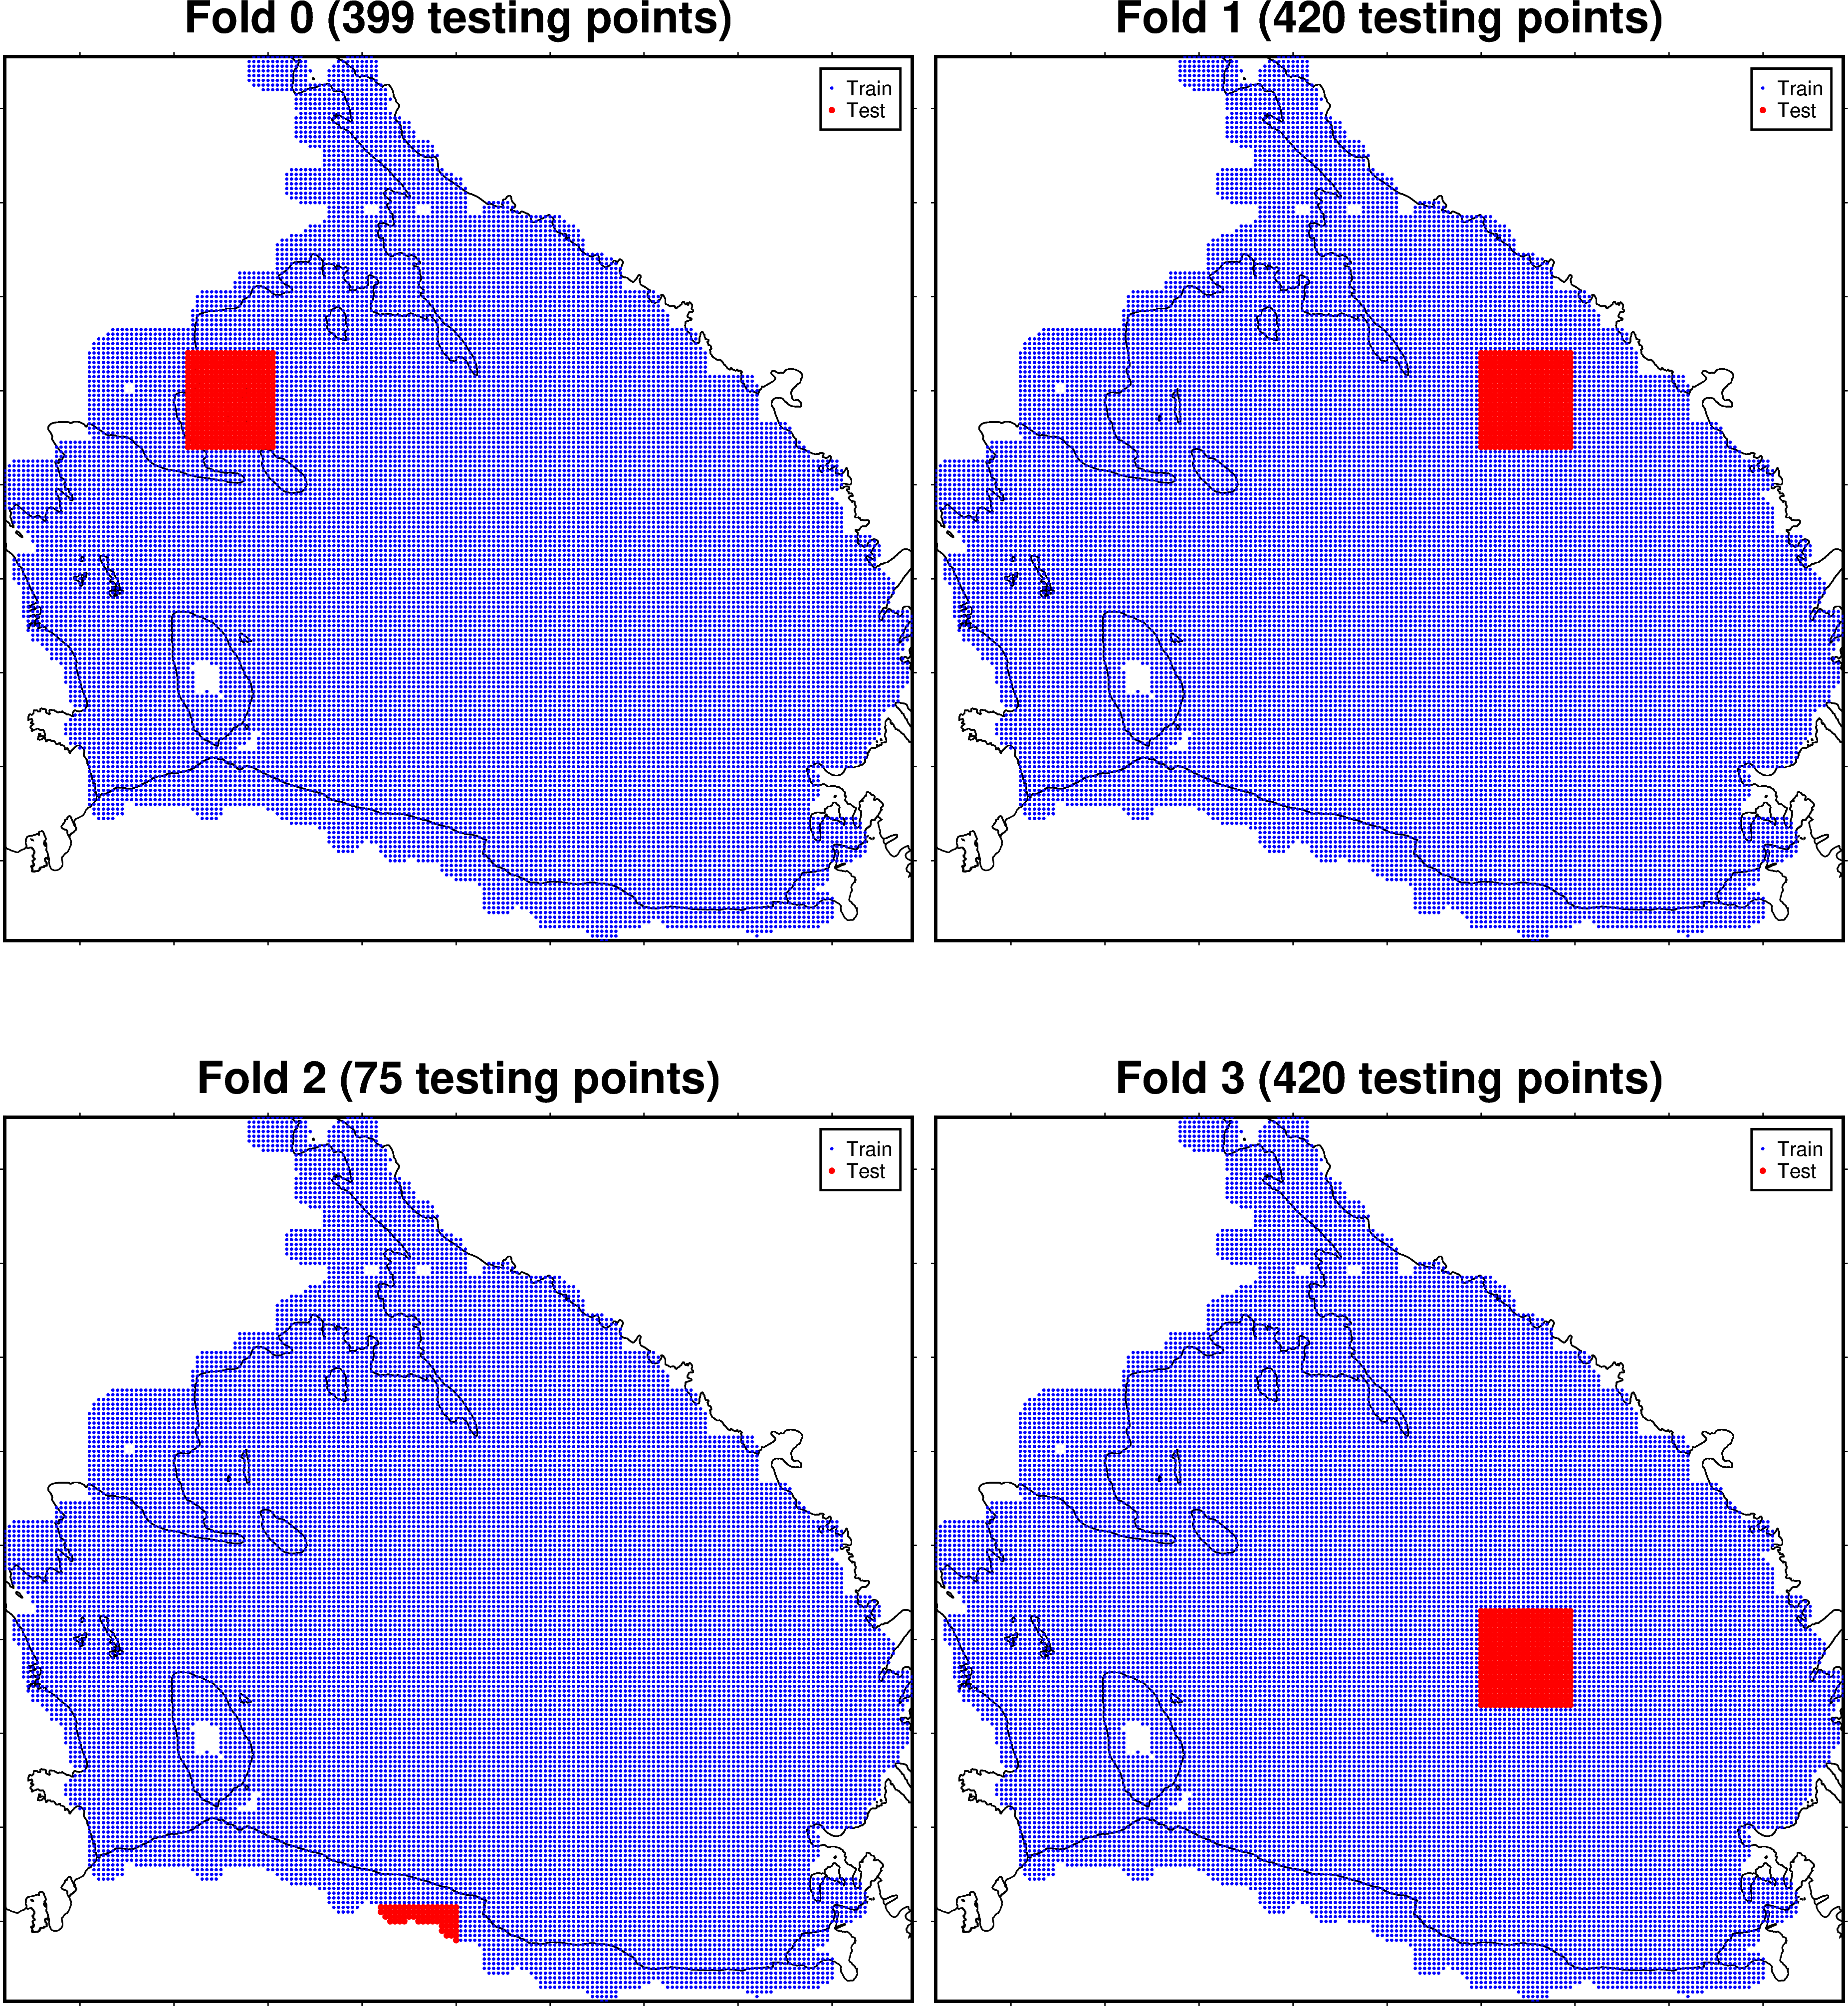

In [36]:
number_to_plot = 4

df = df_anomalies.copy()
blocks = list(df.block_label.unique())

if number_to_plot is not None:
    random.seed(0)
    blocks = random.sample(blocks, number_to_plot)

_, ncols = utils.square_subplots(len(blocks))

for i, b in enumerate(blocks):
    if i == 0:
        fig = (None,)
        origin_shift = "initialize"
        xshift_amount = None
        yshift_amount = None
    elif i % ncols == 0:
        fig = fig
        origin_shift = "both_shift"
        xshift_amount = -ncols + 1
        yshift_amount = -1
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1
        yshift_amount = 1

    df_test = df[df.block_label == b]
    df_train = df[df.block_label != b]

    fig = maps.basemap(
        region=vd.get_region((df.easting, df.northing)),
        title=f"Fold {i} ({len(df_test)} testing points)",
        coast=True,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
        fig=fig,
    )

    fig.plot(
        x=df_train.easting,
        y=df_train.northing,
        style="c.05c",
        fill="blue",
        label="Train",
    )
    fig.plot(
        x=df_test.easting,
        y=df_test.northing,
        style="c.1c",
        fill="red",
        label="Test",
    )

    fig.legend()
fig.show()

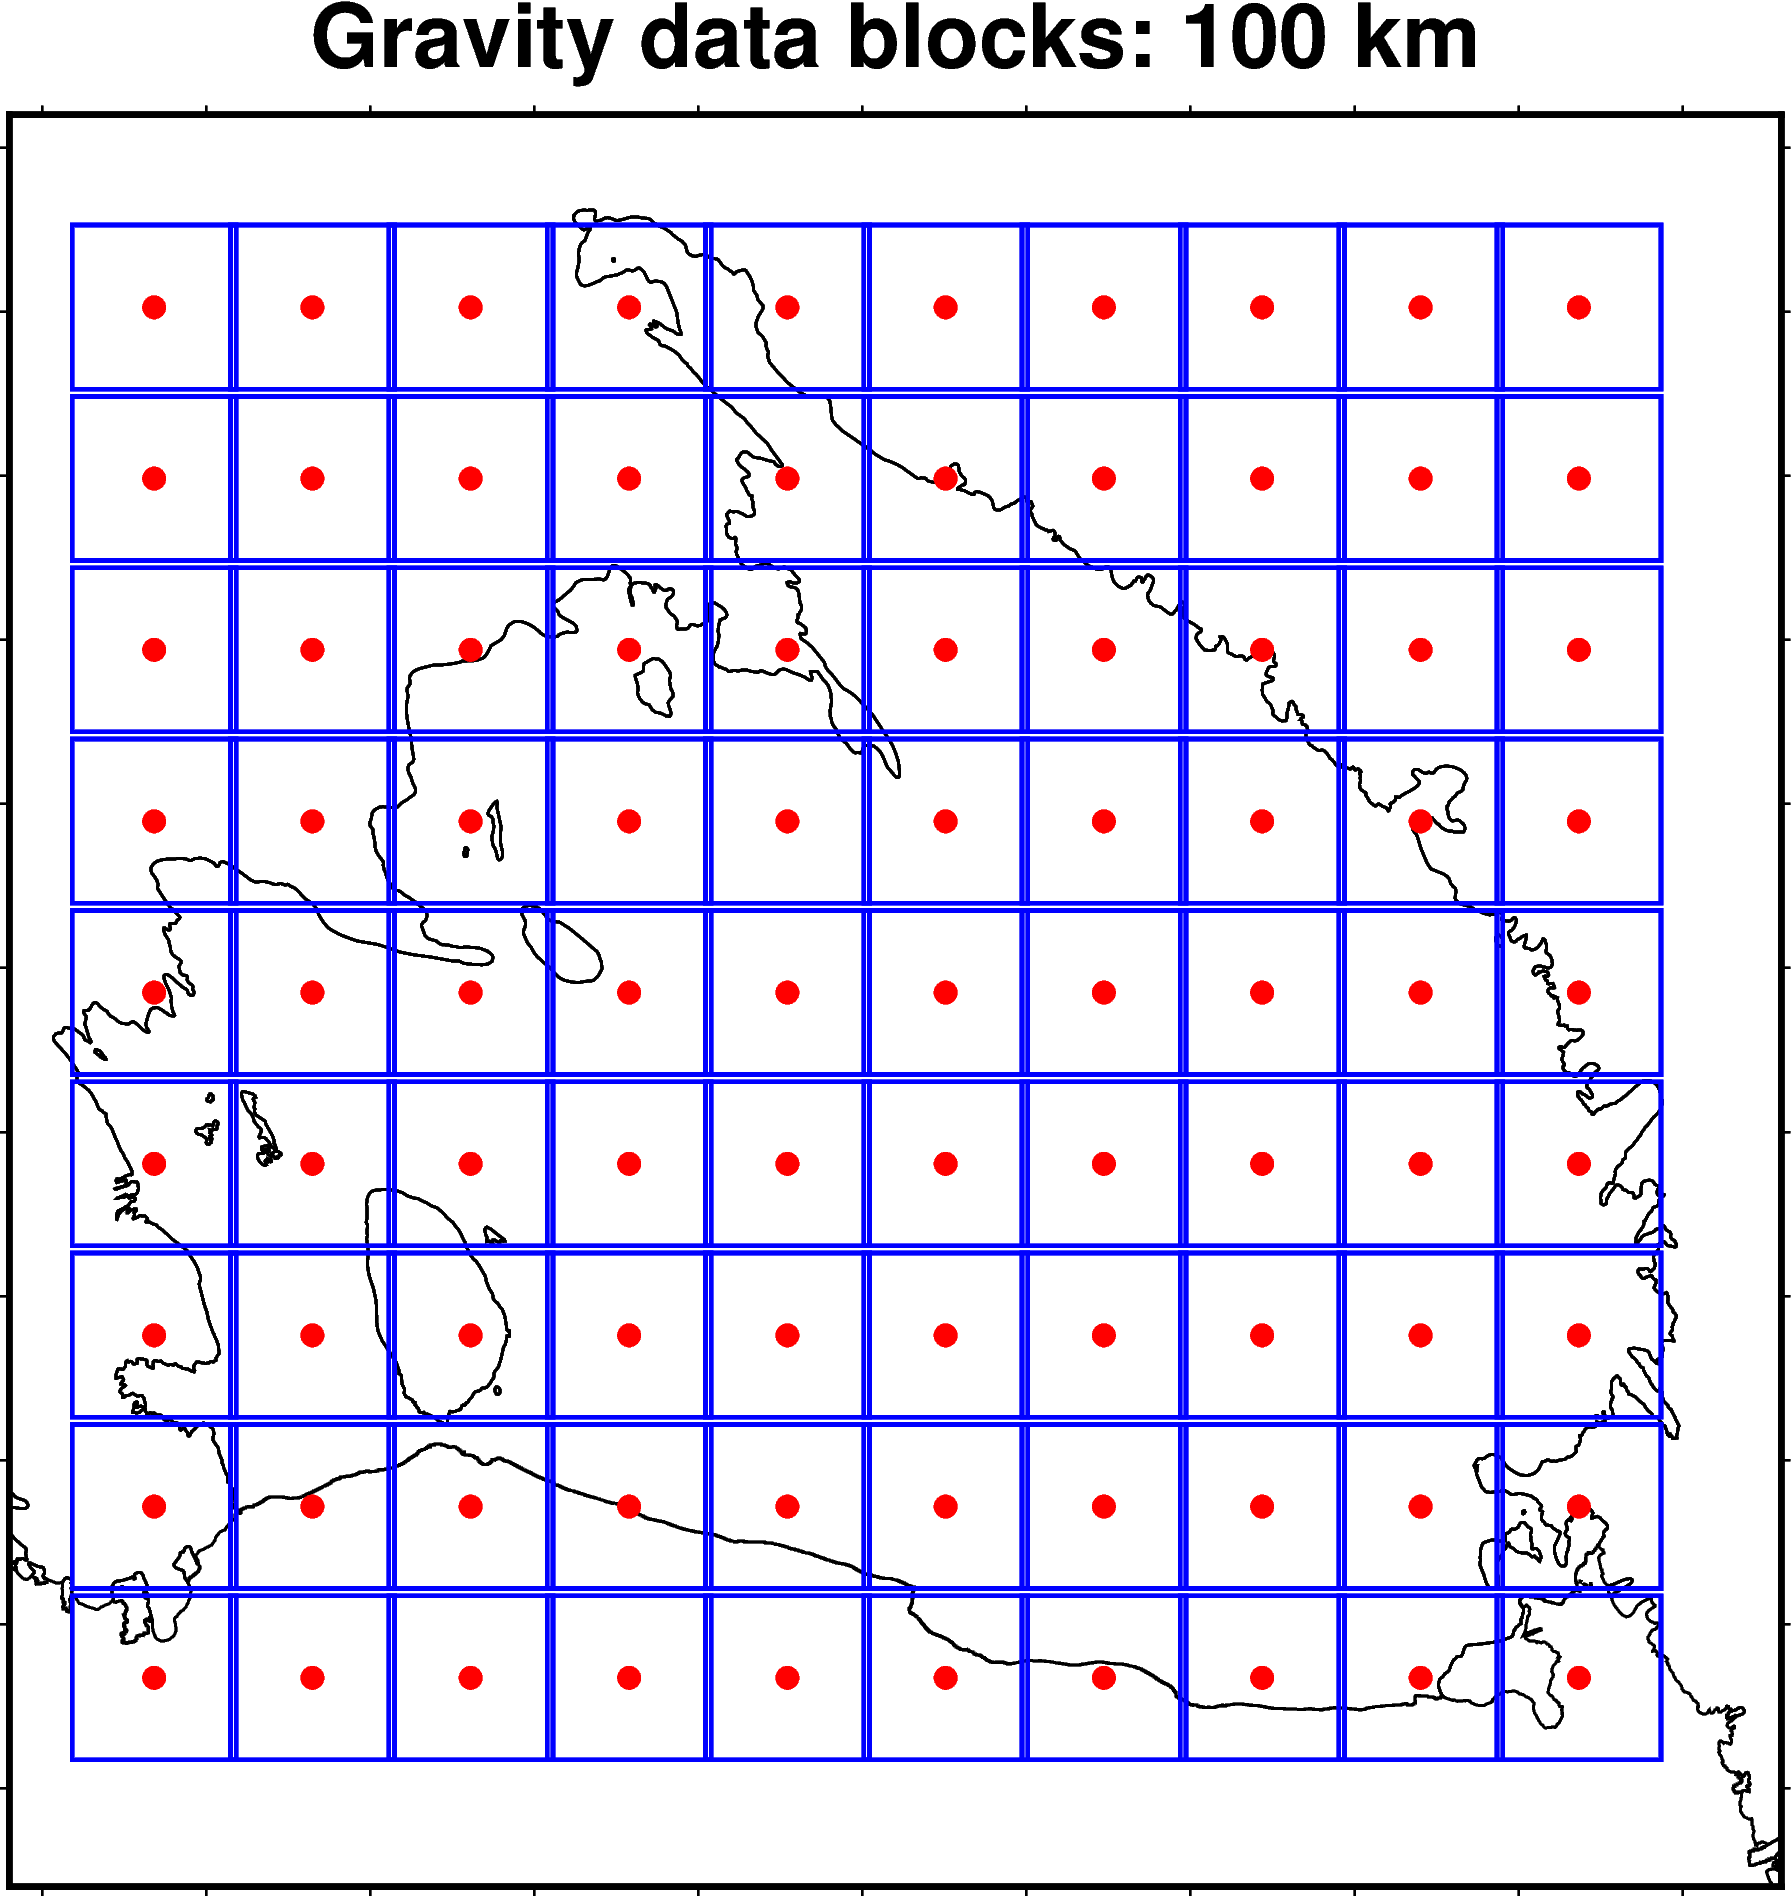

In [37]:
# plot block centers and boxes
fig = maps.basemap(
    region=buffer_region,
    coast=True,
    title=f"Gravity data blocks: {int(block_spacing/1e3)} km",
)

fig.plot(
    x=block_centers[0],
    y=block_centers[1],
    style="c0.2c",
    fill="red",
)

for x, y in zip(block_centers[0], block_centers[1]):
    region = [
        x - block_spacing / 2,
        x + block_spacing / 2,
        y - block_spacing / 2,
        y + block_spacing / 2,
    ]
    maps.add_box(fig, region, pen="1p,blue")

fig.show()

# Run boot-strapping with gravity data

In [7]:
inversion_args = {
    "prism_layer": starting_prisms,
    "input_grav_column": "Gobs_corr_shift",
    "apply_weights": True,
    "max_iterations": 10,
    "l2_norm_tolerance": 0.2,
    "delta_l2_norm_tolerance": 0.8,
    "perc_increase_limit": 0.2,
    "upper_confining_layer": icebase_layer_spacing,
    "deriv_type": "annulus",
    "solver_type": "scipy least squares",
    "solver_damping": 0.1,
}

# get list of blocks
blocks = list(df_anomalies.block_label.unique())

# for each block, remove the gravity data within, run inversion on remaining data and
# return the final topography

# for i, b in enumerate(blocks):
#     topo = inv_utils.inversion_gravity_cross_val_score(
#         df_anomalies[df_anomalies.block_label!=b],
#         inversion_args = inversion_args,
#         calculate_anomalies = False,
#     ).to_dataset(name=f"block_{b}")

#     if i == 0:
#         mode = "w"
#     else:
#         mode = "a"

#     enc = {x: {"compressor": zarr.Blosc()} for x in topo}
#     topo.to_zarr(
#         "../data/CV_gravity_topos.zarr",
#         encoding=enc,
#         mode=mode,
#     )
# print(f"Finished inversion {i} of {len(blocks}")

In [9]:
# load dataset with all the topo models
topos = xr.open_zarr("../data/CV_gravity_topos.zarr")

# merge variables into a single variable with a new axis "folds"
variables = list(topos)
ds_merged = (
    xr.concat([topos[var] for var in variables], dim="folds")
    .assign_coords({"folds": variables})
    .rename("fold_num")
    .to_dataset()
)
ds_merged

<xarray.Dataset>
Dimensions:   (easting: 217, northing: 217, folds: 71)
Coordinates:
  * easting   (easting) float64 -6.2e+05 -6.15e+05 -6.1e+05 ... 4.55e+05 4.6e+05
  * northing  (northing) float64 -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
  * folds     (folds) <U8 'block_10' 'block_11' ... 'block_84' 'block_9'
Data variables:
    fold_num  (folds, northing, easting) float64 dask.array<chunksize=(1, 109, 217), meta=np.ndarray>

In [6]:
# for t in list(topos):
#     fig = topos[t].plot()
#     plt.savefig(f"../data/topo_figs/{t}.png")

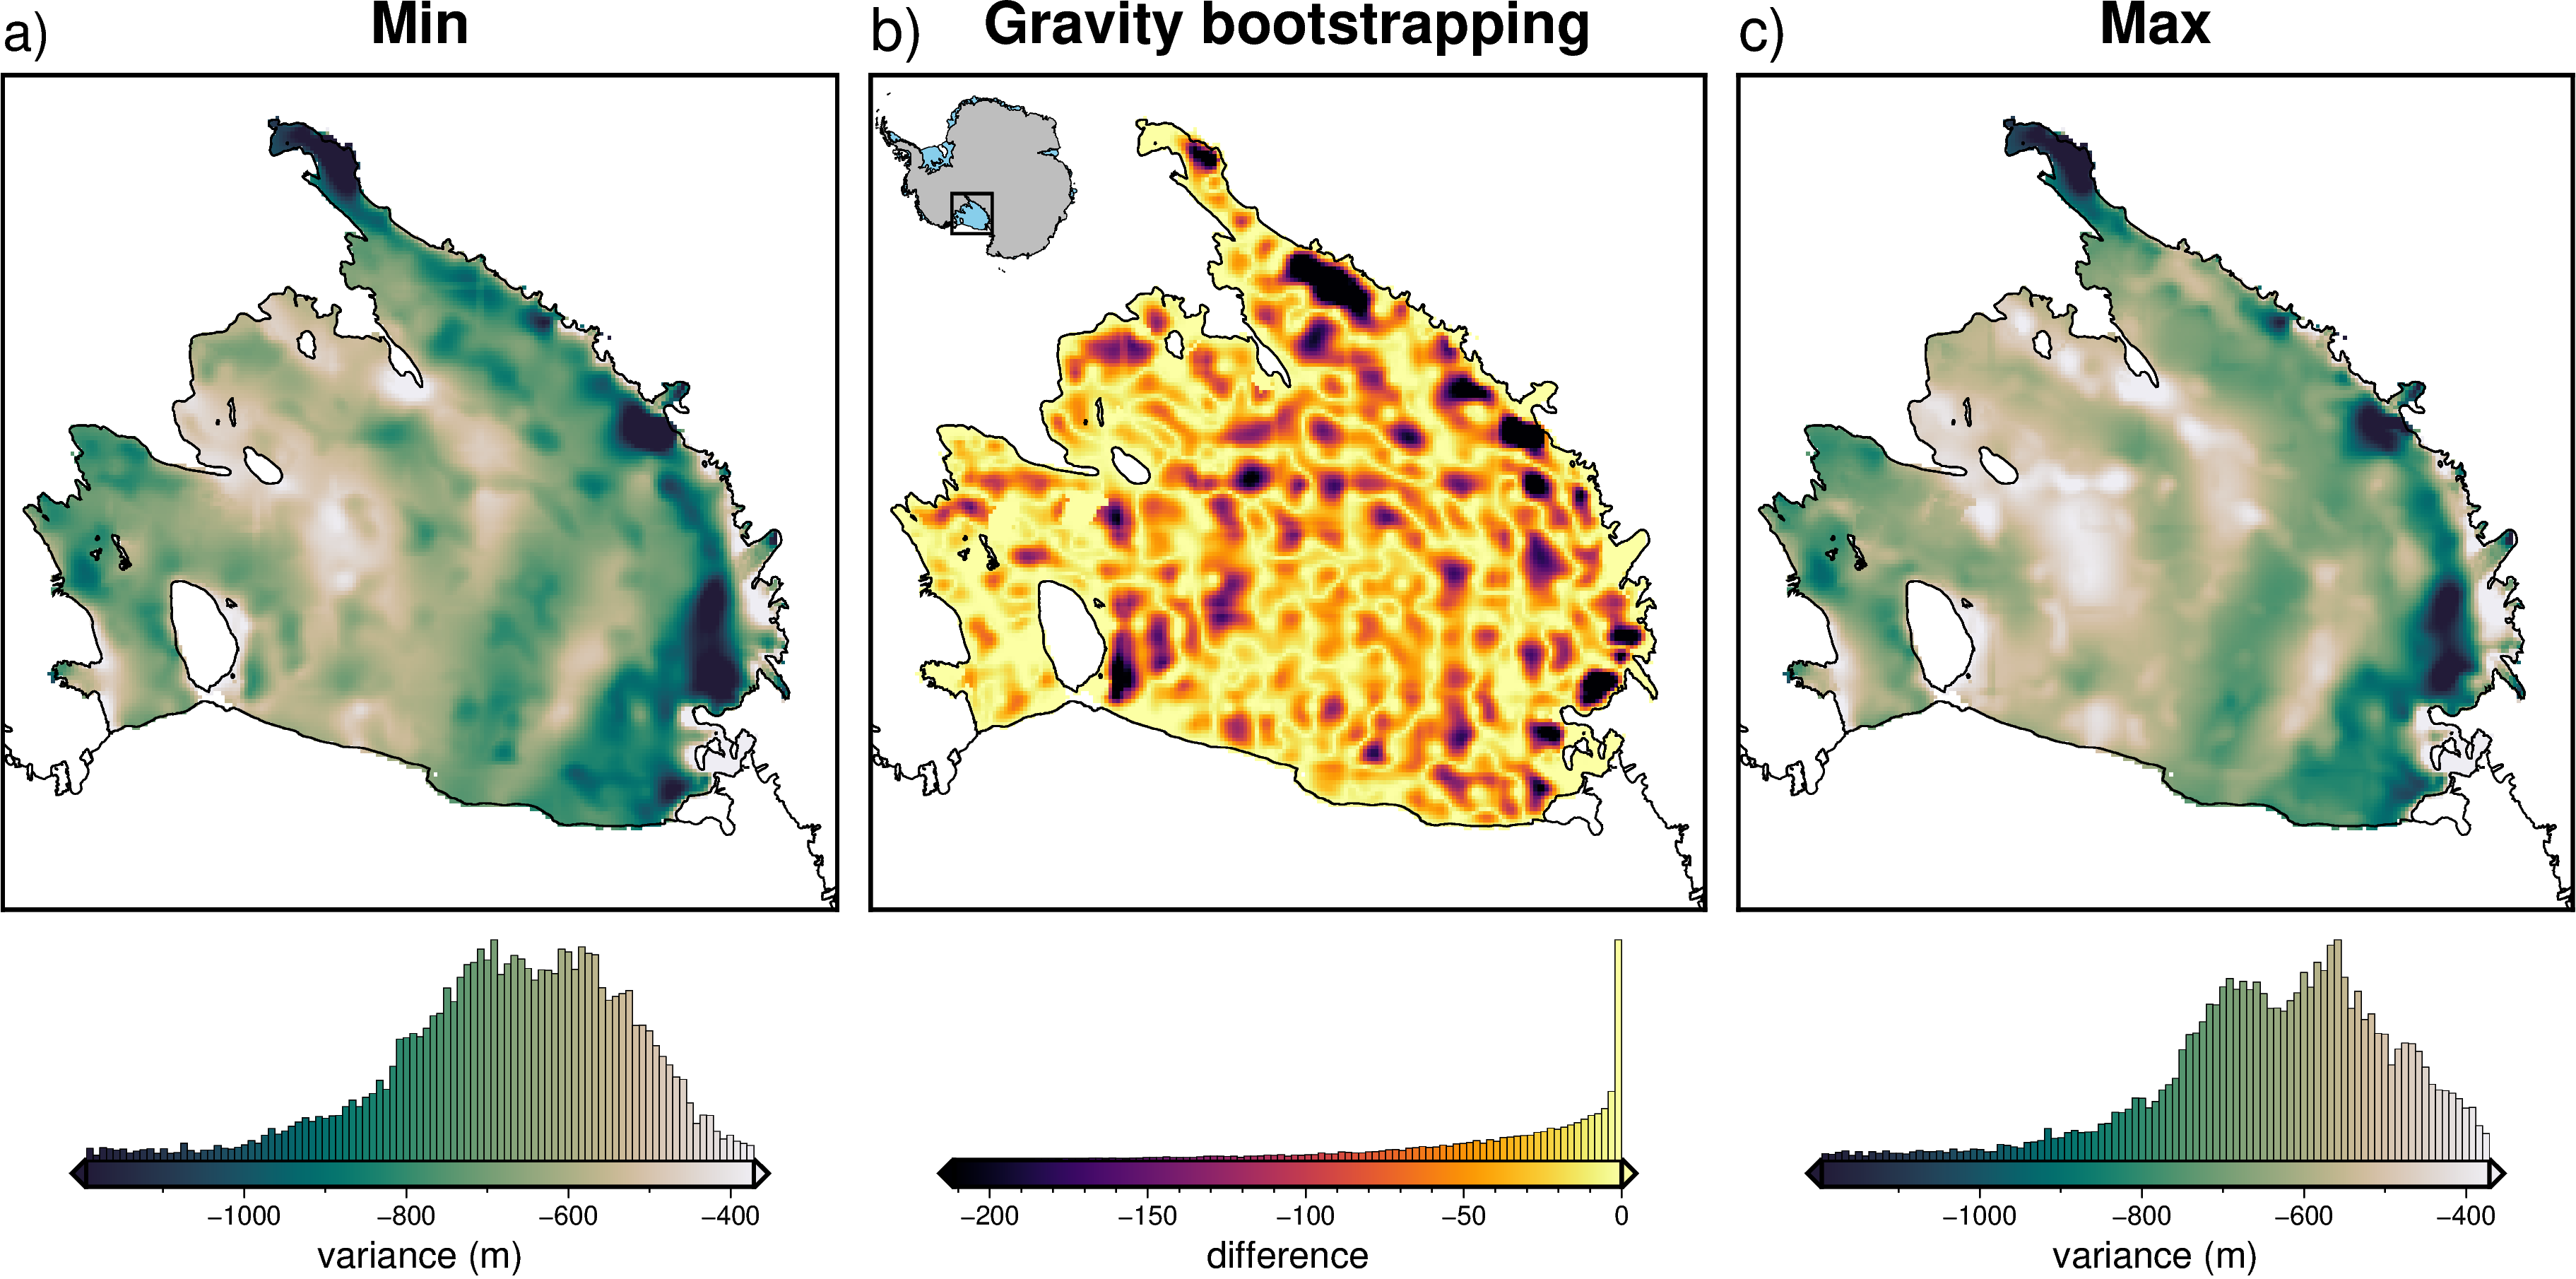

In [10]:
merged_min = ds_merged["fold_num"].min("folds")
merged_max = ds_merged["fold_num"].max("folds")
merged_min = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=merged_min,
    masked=True,
    invert=False,
)
merged_max = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=merged_max,
    masked=True,
    invert=False,
)

_ = utils.grd_compare(
    merged_min,
    merged_max,
    plot=True,
    grid1_name="Min",
    grid2_name="Max",
    title="Gravity bootstrapping",
    cbar_label="variance (m)",
    diff_cmap="inferno",
    diff_maxabs=False,
    cmap="rain",
    reverse_cpt=True,
    rmse_in_title=False,
    subplot_labels=True,
    robust=True,
    hist=True,
    # shp_mask="../plotting/RIS_outline.shp",
)

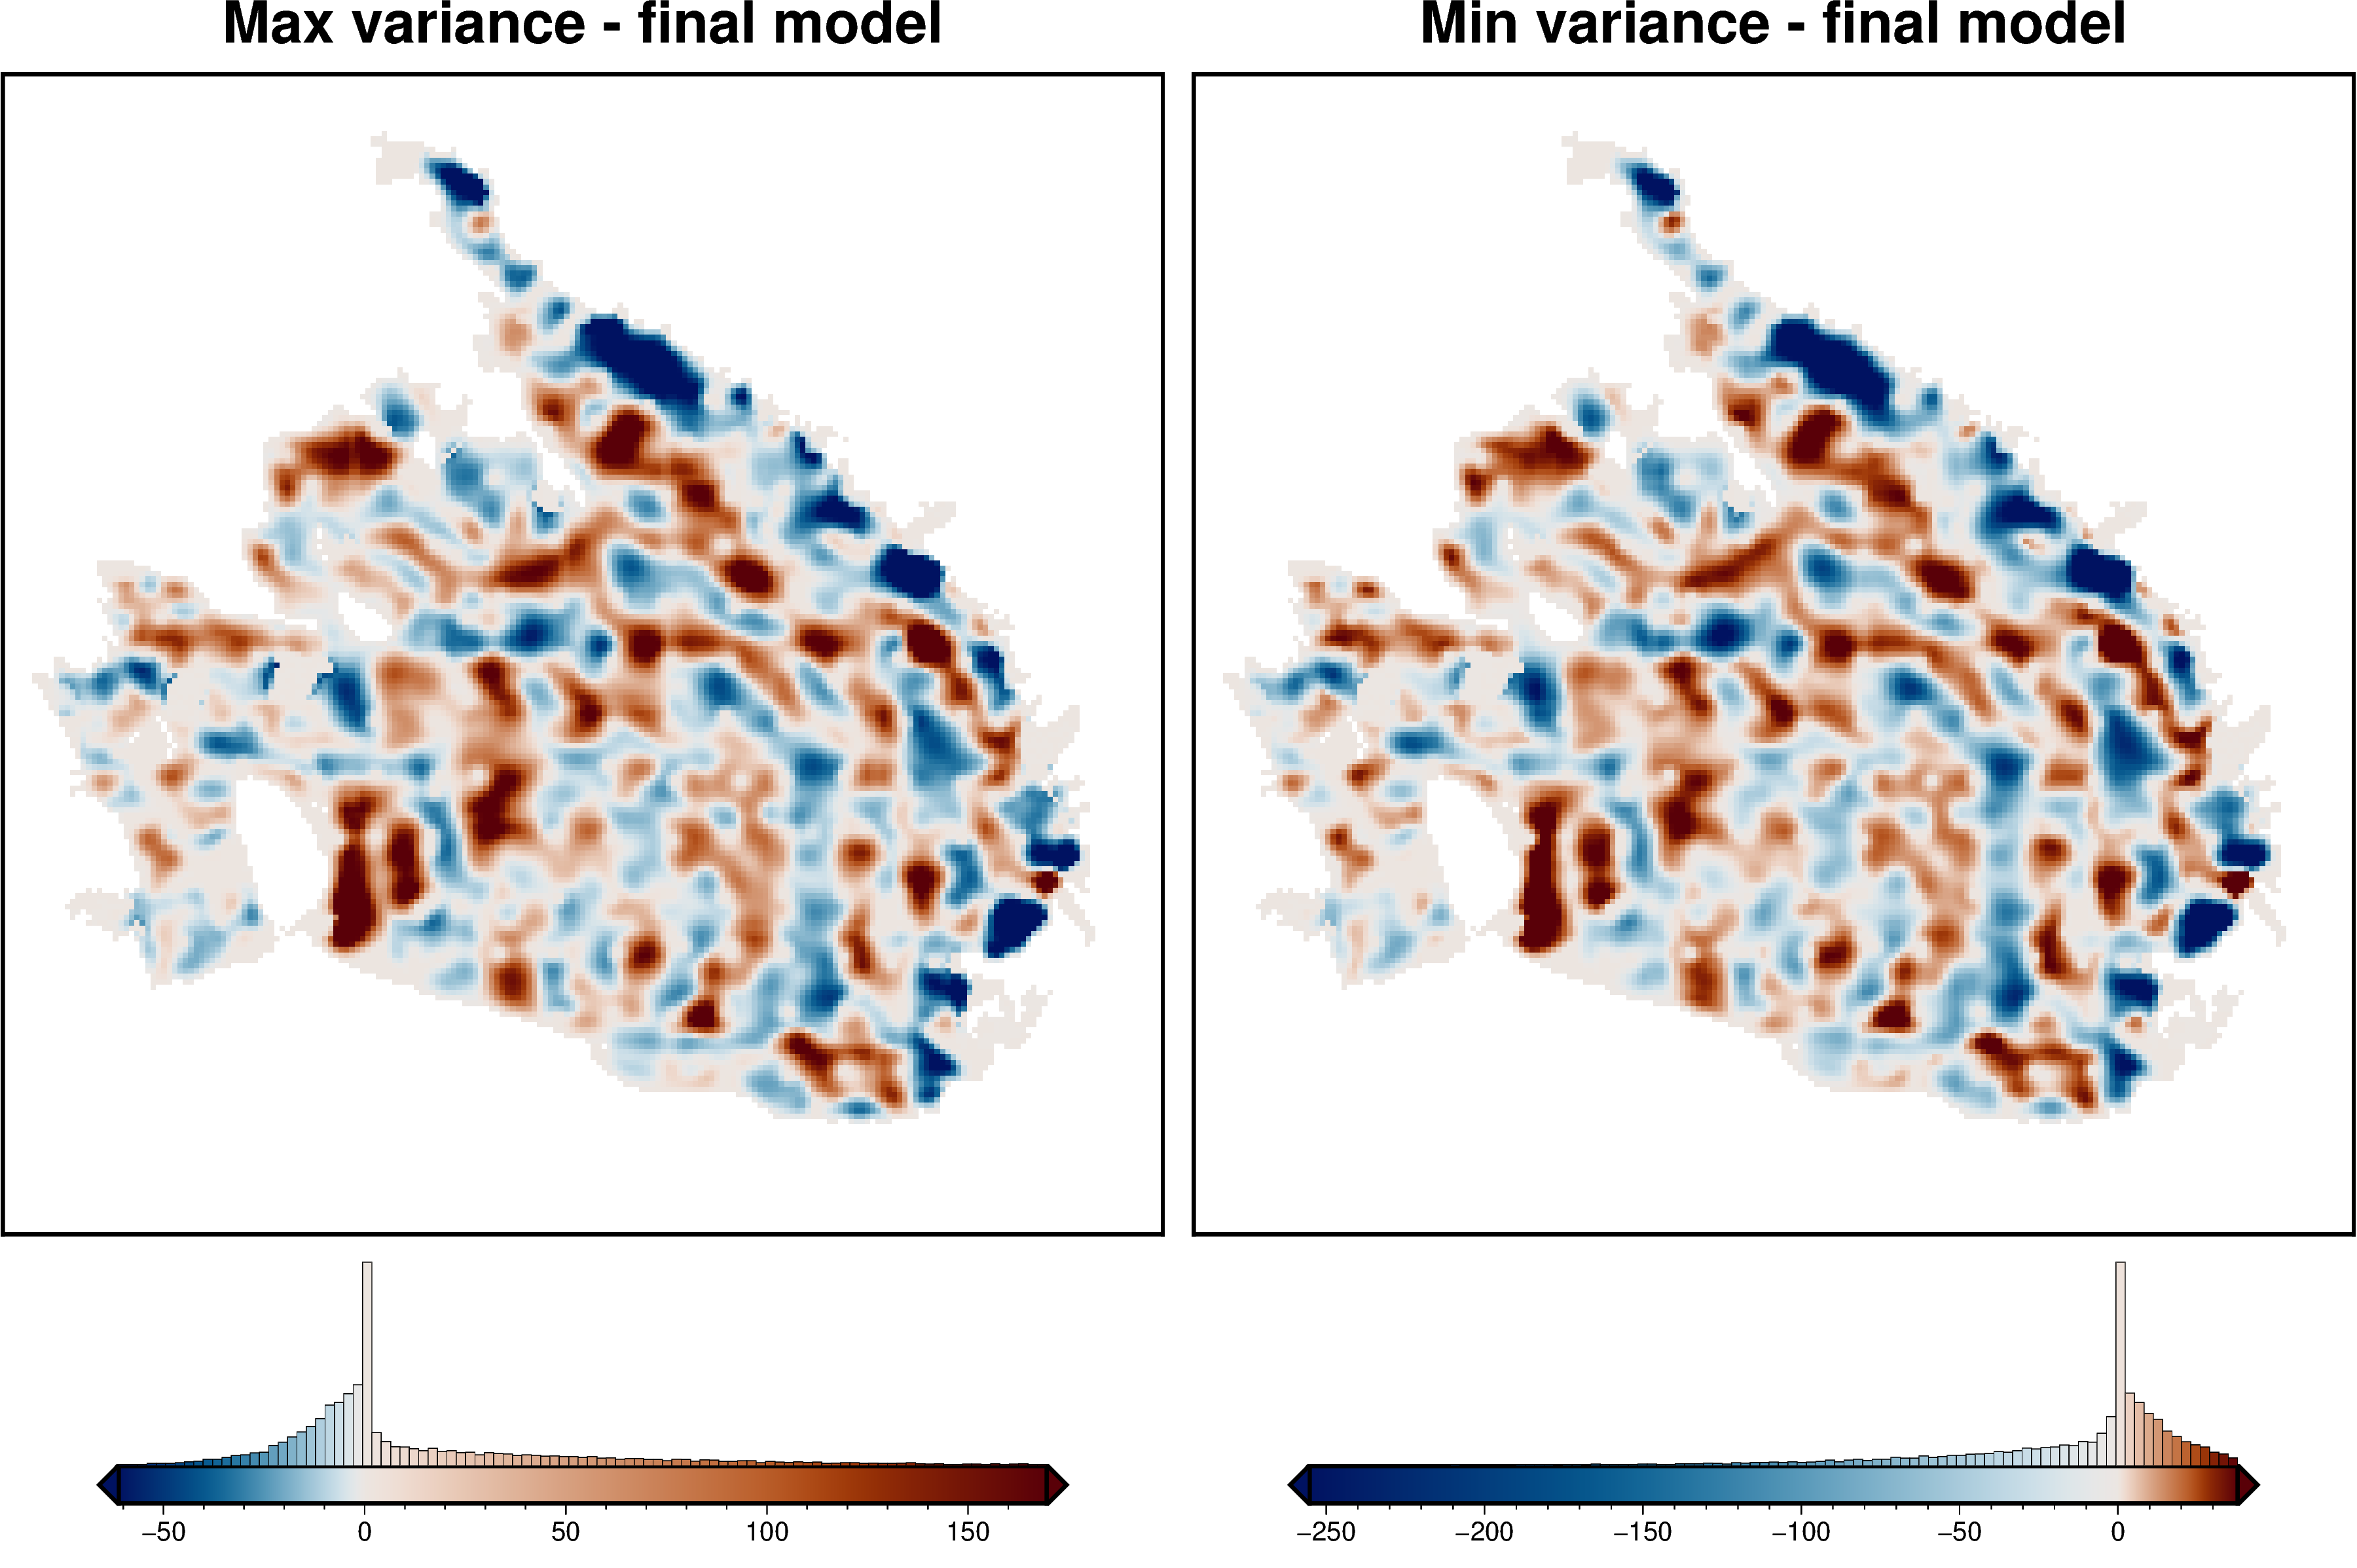

In [83]:
inverted_bathy_mask = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=inverted_bathy,
    masked=True,
    invert=False,
)
max_to_final = merged_max - inverted_bathy_mask
min_to_final = merged_min - inverted_bathy_mask

fig = maps.plot_grd(
    max_to_final,
    title="Max variance - final model",
    cmap="vik+h0",
    robust=True,
    hist=True,
)
fig = maps.plot_grd(
    min_to_final,
    title="Min variance - final model",
    cmap="vik+h0",
    robust=True,
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.show()

In [ ]:
stdev = ds_merged["fold_num"].std("folds").rename("stdev")
stdev = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp", xr_grid=stdev, masked=True, invert=False
)

fig = maps.plot_grd(
    stdev,
    cmap="inferno",
    reverse_cpt=True,
    robust=True,
    hist=True,
    cbar_label="standard deviation (m)",
    title='"Leave-one-out" cross-validation of gravity data',
)

fig.plot(
    x=constraints.easting,
    y=constraints.northing,
    fill="gray",
    style="c.02c",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    fill="gray",
    pen=".1p,black",
    style="c.07c",
    label="Bed constraints",
)
fig.legend()

fig.show()

# Other stuff

In [ ]:
# fig = maps.basemap(
#     region=buffer_region,
#     coast=True,
# )

# for x, y in zip(blocks[0], blocks[1]):
#     fig.plot(
#         x = x,
#         y = y,
#         style="c0.3c",
#         fill="red",
#     )

# fig.show()

In [72]:
# train, test = vd.train_test_split(
#     (df_anomalies.easting, df_anomalies.northing),
#     data = df_anomalies.res,
#     # spacing=50e3,
#     shape = (10,10),
# )
# test

In [69]:
# fig = maps.basemap(
#     region=buffer_region,
#     coast=True,
# )
# # for x, y in zip(test[0][0], test[0][1]):
# fig.plot(
#     x = train[0][0],
#     y = train[0][1],
#     style="c0.01c",
#     fill="blue",
# )
# fig.plot(
#     x = test[0][0],
#     y = test[0][1],
#     style="c0.1c",
#     fill="red",
# )

# fig.show()

In [70]:
# df_anomalies.describe()

In [71]:
# df_test_train = inv_utils.split_gravity_test_train(
#     df_anomalies,
#     # spacing = 100e3,
#     shape = (20,2),
#     n_splits = 10,
#     test_size = 1,
#     plot=True,
#     number_to_plot = 2,
# )
# # print(f"Test points in fold 0: {len(df_test_train[df_test_train.fold_0==' test'])}")
# df_test_train